In [ ]:
%pip install folium
%pip install esda libpysal

import folium
import geopandas as gpd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from esda.moran import Moran
from libpysal.weights import Queen


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [117]:
df = pd.read_csv("KR_cleaned_df.csv")
df.head()

,Unnamed: 0,V012,V024,V026,V102,V106,V113,V190,B5,B6,...,H37E,H37AA,H37AB,H37H,H37I,H37J,H37K,H37L,H37M,H37X
0,0,30.0,11.0,1.0,1.0,0.0,13.0,3.0,1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,35.0,11.0,1.0,1.0,0.0,13.0,3.0,1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,35.0,11.0,1.0,1.0,0.0,13.0,3.0,2.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,35.0,11.0,1.0,1.0,0.0,13.0,3.0,2.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,35.0,11.0,1.0,1.0,0.0,13.0,3.0,2.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Analysis and Advanced Exploration

Data was divided into multiple categories:
1. Geographic location
2. If child is alive or dead + Age
3. Sickness Symptoms
4. Response Dimension
5. Exposure Dimension
6. Context/Environment

The question "Are there geographical hotspots for children under 5 mortality and morbidity"? is a spatial epidemiology question.
Child morbidity, exposures, and enviornment are context that help explain later why clusters exist but isn't strictly needed to detect hotspots.

### Exploration will take two steps

1. Descriptive/spatial: Where are mortality and morbisity higher than expected?
2. Explanatory: What factors explain why those areas have higher risk?

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19491 entries, 0 to 19490
Data columns (total 71 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  19491 non-null  int64  
 1   V012        19491 non-null  float64
 2   V024        19491 non-null  float64
 3   V026        19491 non-null  float64
 4   V102        19491 non-null  float64
 5   V106        19491 non-null  float64
 6   V113        19491 non-null  float64
 7   V190        19491 non-null  float64
 8   B5          19491 non-null  float64
 9   B6          19491 non-null  float64
 10  B7          19491 non-null  float64
 11  B8          19491 non-null  float64
 12  M13         19491 non-null  float64
 13  M15         19491 non-null  float64
 14  M18         19491 non-null  float64
 15  H11         19491 non-null  float64
 16  H12A        19491 non-null  float64
 17  H12B        19491 non-null  float64
 18  H12C        19491 non-null  float64
 19  H12D        19491 non-nul

In [119]:
df = df.rename(columns={"Unnamed: 0": "idx"})

In [120]:
def convert_binary(col):
    df.loc[df[col] == 2.0, col] = 0

In [121]:
# non_binary = ['V012', 'V024', 'V026', 'V102', 'V113', 'B6', 'B7', 'B8', 'M13', 'M15', 'M18']
binary = ["B5", "H11", "H22", "H31", "H31B"]
for cat in binary:
    convert_binary(cat)

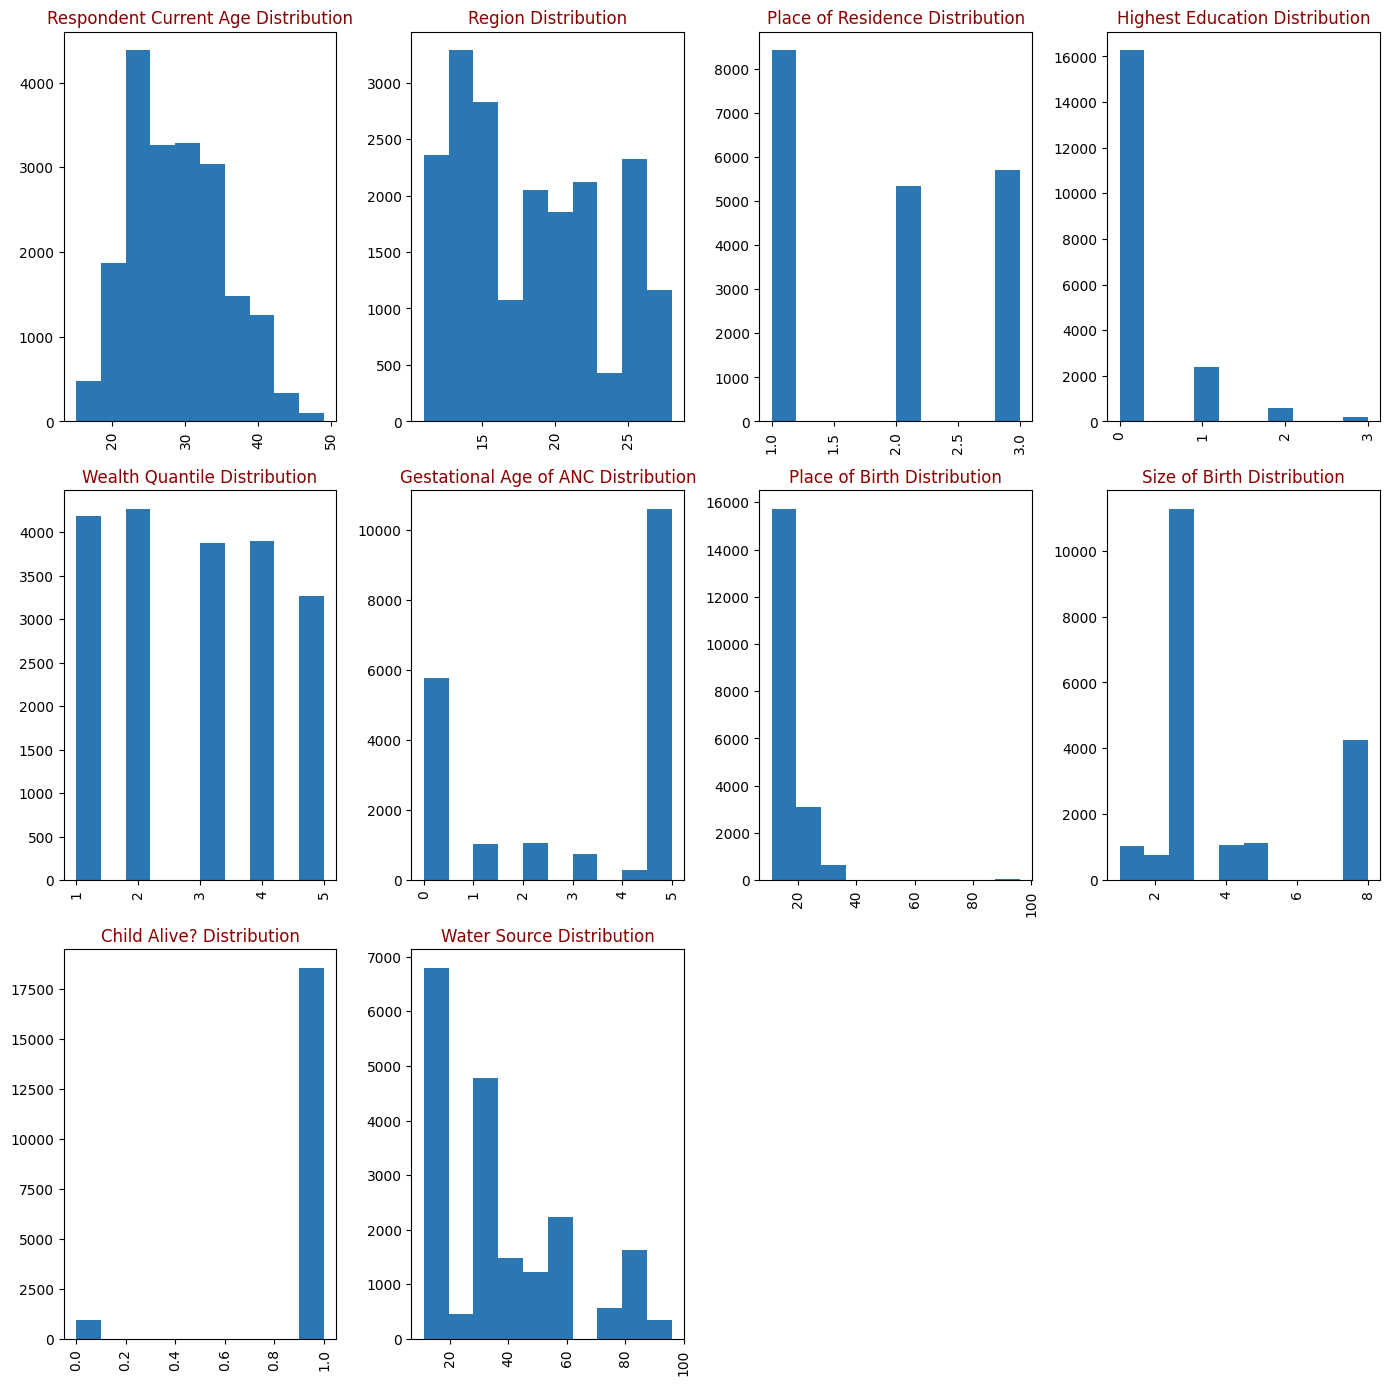

In [ ]:
np.random.seed(0)

# Define the column names for the histograms
column_names = [
    "V012",
    "V024",
    "V102",
    "V106",
    "V190",
    "M13",
    "M15",
    "M18",
    "B5",
    "V113",
]
column_map = {
    "V012": "Respondent Current Age",
    "V024": "Region",
    "V102": "Place of Residence",
    "M15": "Place of Birth",
    "V113": "Water Source",
    "V190": "Wealth Quantile",
    "V106": "Highest Education",
    "M18": "Size of Birth",
    "M13": "Gestational Age of ANC",
    "B5": "Child Alive?",
}

# Determine the number of rows and columns for subplots
num_rows = 3
num_cols = 4

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over the column names and plot the histograms
for i, col_name in enumerate(column_names):
    ax = axes[i]
    ax.hist(df[col_name], bins=10, facecolor="#2b77b4")
    ax.set_title(column_map[col_name] + " Distribution", color="DarkRed")
    ax.tick_params(axis="x", rotation=90)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Measuring percentage of Alive children under 5 for every region

In [123]:
region_count = df["V024"].value_counts(sort=False)

In [124]:
children_alive = 1 - df.groupby("V024")["B5"].sum() / region_count
children_alive

V024
11.0    0.051064
12.0    0.043724
13.0    0.084586
14.0    0.073373
15.0    0.055236
16.0    0.048535
17.0    0.049120
18.0    0.043021
19.0    0.045908
20.0    0.030905
21.0    0.037895
22.0    0.025012
24.0    0.069930
25.0    0.045455
26.0    0.031334
28.0    0.043141
dtype: float64

Region 11 has the least percentage of alive children which refer to "Awdal", and the highest is for Region 22 "Banadir"

Let's relate child alive and dead with wealth quantile and education

### Wealth Quantile (V190)
- 1: Lowest
- 2: Second
- 3: Middle
- 4: Fourth
- 5: Highest

In [125]:
wealth = df["V190"].value_counts(sort=False)
df.groupby("V190")["B5"].sum() / wealth  # I see no pattern between wealth and mortality

V190
1.0    0.953850
2.0    0.956399
3.0    0.947545
4.0    0.943135
5.0    0.955644
dtype: float64

### Highest Education Level (V106)
- 0: No Education
- 1: Primary
- 2: Secondary
- 3: Higher

Text(0.5, 1.0, 'Distribution of Highest Education Level (V106)')

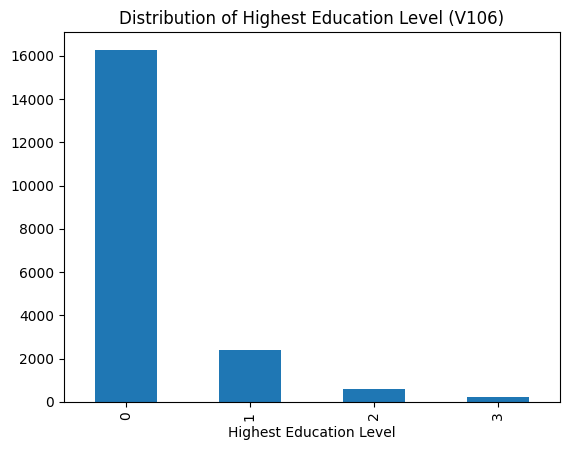

In [126]:
order = [0, 1, 2, 3]

df["V106"] = pd.Categorical(df["V106"], categories=order, ordered=True)

education = df["V106"].value_counts(sort=False)
education.plot(kind="bar")
plt.xlabel("Highest Education Level")
plt.title("Distribution of Highest Education Level (V106)")

In [127]:
df.groupby("V106")["B5"].sum() / education

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_27649/2019080148.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("V106")['B5'].sum() / education


V106
0    0.950464
1    0.952579
2    0.965116
3    0.962617
dtype: float64

The dataset focuses on children under 5 years old. To ensure the analysis is restricted to this age group, I filtered the data using the variables "B7" (age at death in months) and "B8" (age of alive children). Specifically, I excluded records where B7 is greater than 60 months and B8 is greater than 5 years, keeping only relevant entries for children under 5.

In [128]:
df = df[df["B7"] < 60]

In [129]:
df = df[df["B8"] < 5]

"B7" is the age of child at death in months. Most of the data belong to alive children. For alive children, B7 encode those with the value -1 as dead. It's fair to exclude those to understand the distribution of age in dead children

I think although the values that are outside the age range are very minimal but it's wise to exclude them.

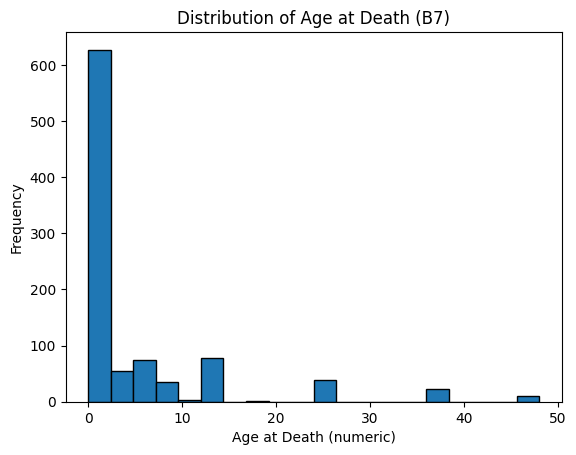

In [130]:
b7_clean = df["B7"][df["B7"] != -1]

# Plot histogram
plt.hist(b7_clean, bins=20, edgecolor="black")
plt.xlabel("Age at Death (numeric)")
plt.ylabel("Frequency")
plt.title("Distribution of Age at Death (B7)")
plt.show()

I think although the values that are outside the age range are very minimal but it's wise to exclude them.

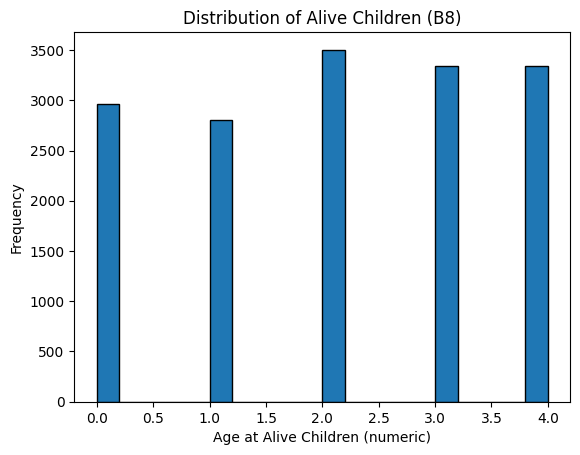

In [131]:
b8_clean = df["B8"][df["B8"] != -1]

# Plot histogram
plt.hist(b8_clean, bins=20, edgecolor="black")
plt.xlabel("Age at Alive Children (numeric)")
plt.ylabel("Frequency")
plt.title("Distribution of Alive Children (B8)")
plt.show()

Children with sickness (morbidity)

Text(0.5, 1.0, 'Distribution of Children with Diarrhea (H11)')

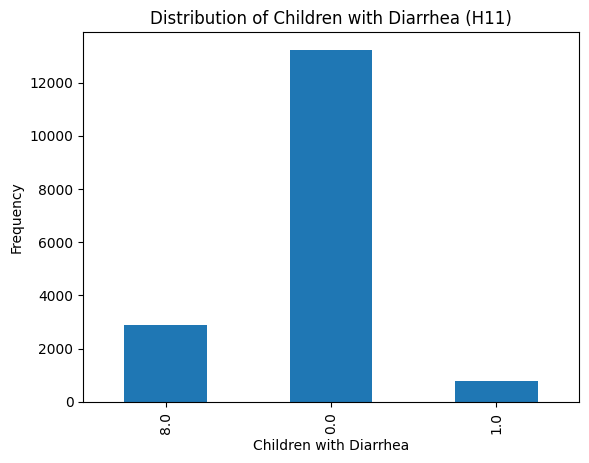

In [132]:
df["H11"].value_counts(sort=False).plot(kind="bar")
plt.xlabel("Children with Diarrhea")
plt.ylabel("Frequency")
plt.title("Distribution of Children with Diarrhea (H11)")

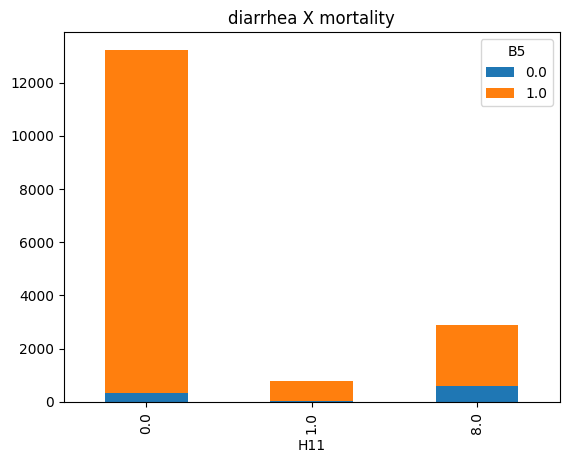

In [133]:
table = pd.crosstab(df["H11"], df["B5"])
table.plot(kind="bar", stacked=True)
plt.title("diarrhea X mortality")
plt.show()

Text(0.5, 1.0, 'Distribution of Children with Fever (H22)')

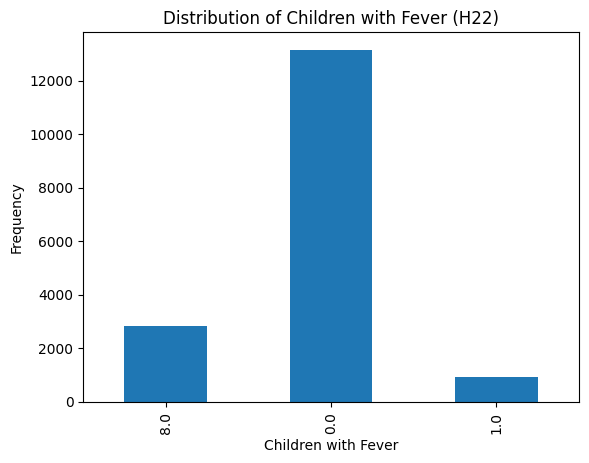

In [134]:
df["H22"].value_counts(sort=False).plot(kind="bar")
plt.xlabel("Children with Fever")
plt.ylabel("Frequency")
plt.title("Distribution of Children with Fever (H22)")

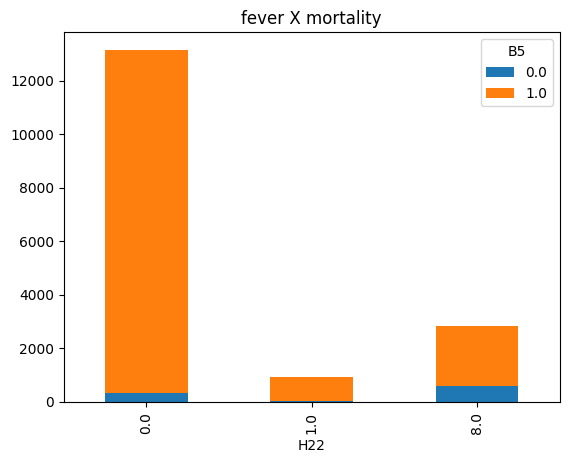

In [135]:
table = pd.crosstab(df["H22"], df["B5"])
table.plot(kind="bar", stacked=True)
plt.title("fever X mortality")
plt.show()

In [136]:
ARI_calc = df[["H31", "H31B"]].sum(axis=1)
df["ARI"] = np.where(ARI_calc == 2, 1, 0)

Text(0.5, 1.0, 'Distribution of Children with ARI')

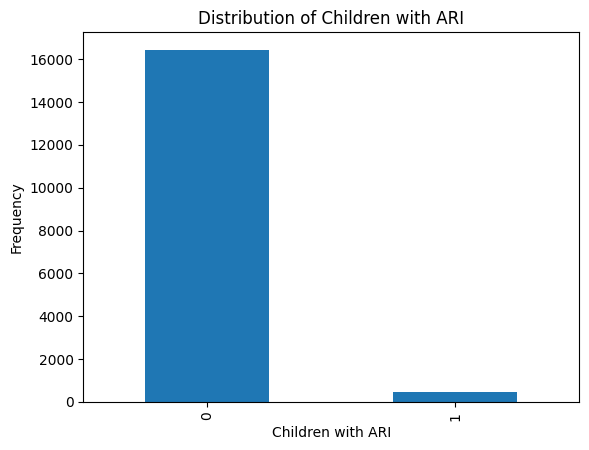

In [137]:
df["ARI"].value_counts(sort=False).plot(kind="bar")
plt.xlabel("Children with ARI")
plt.ylabel("Frequency")
plt.title("Distribution of Children with ARI")

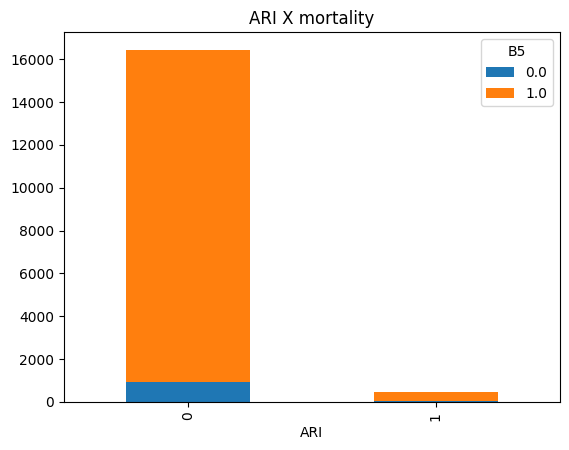

In [138]:
table = pd.crosstab(df["ARI"], df["B5"])
table.plot(kind="bar", stacked=True)
plt.title("ARI X mortality")
plt.show()

In [139]:
df["sickness"] = (df[["ARI", "H22", "H11"]] == 1).any(axis=1).astype(int)

Text(0.5, 1.0, 'Distribution of Children with sickness symptoms')

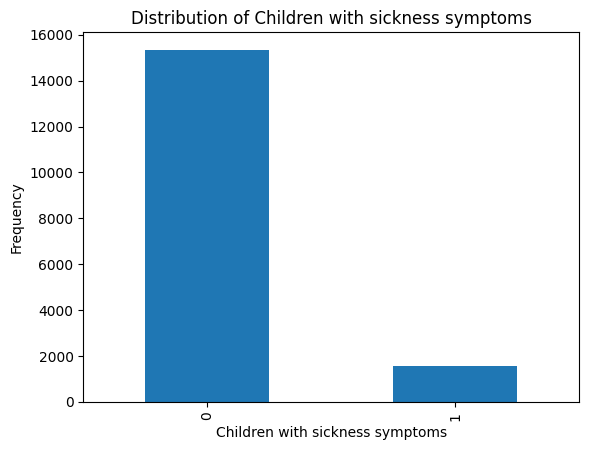

In [140]:
df["sickness"].value_counts(sort=False).plot(kind="bar")
plt.xlabel("Children with sickness symptoms")
plt.ylabel("Frequency")
plt.title("Distribution of Children with sickness symptoms")

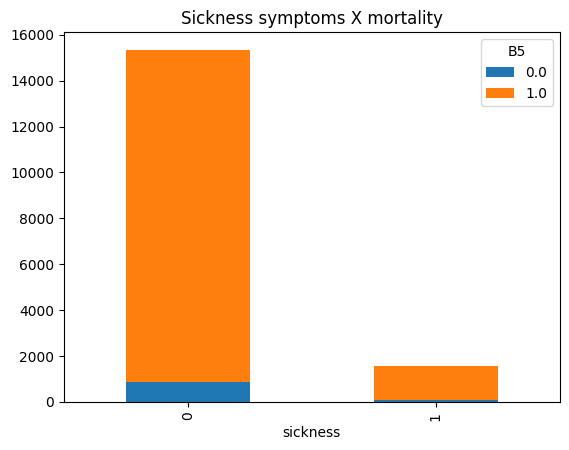

In [141]:
table = pd.crosstab(df["sickness"], df["B5"])
table.plot(kind="bar", stacked=True)
plt.title("Sickness symptoms X mortality")
plt.show()

Since number of alive children is huge, let's just look at cases of mortality to understand associations

In [142]:
alive_df = df[df["B5"] == 1]
dead_df = df[df["B5"] == 0]

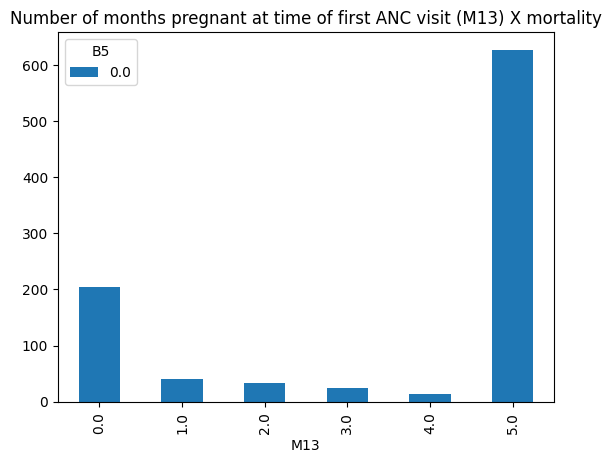

In [143]:
table = pd.crosstab(dead_df["M13"], dead_df["B5"])
table.plot(kind="bar", stacked=True)
plt.title("Number of months pregnant at time of first ANC visit (M13) X mortality")
plt.show()

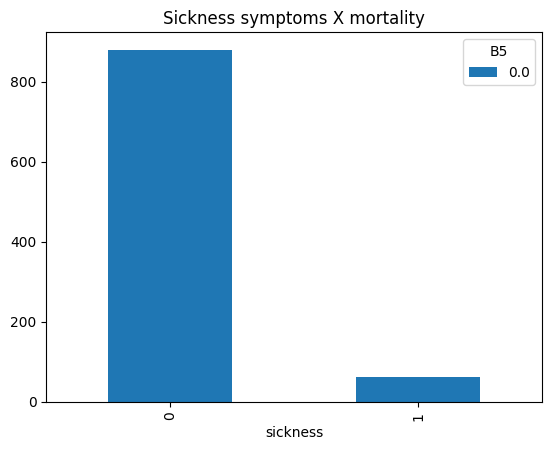

In [144]:
table = pd.crosstab(dead_df["sickness"], dead_df["B5"])
table.plot(kind="bar", stacked=True)
plt.title("Sickness symptoms X mortality")
plt.show()
# Children who didn't show any illness died for other reasons
# I think this should shift focus to other causes that might be related to mortality

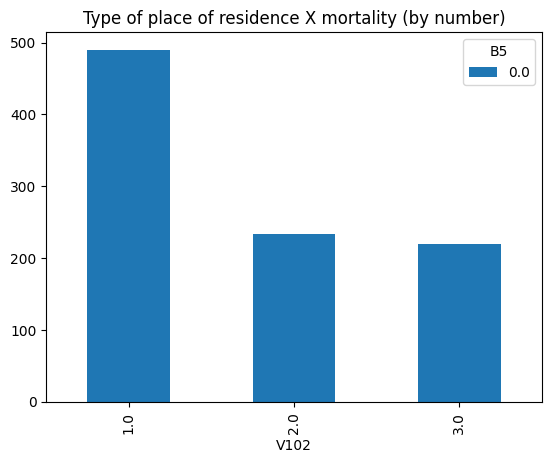

In [145]:
table = pd.crosstab(df["V102"], df["B5"][df["B5"] == 0])
table.plot(kind="bar", stacked=True)
plt.title("Type of place of residence X mortality (by number)")
plt.show()

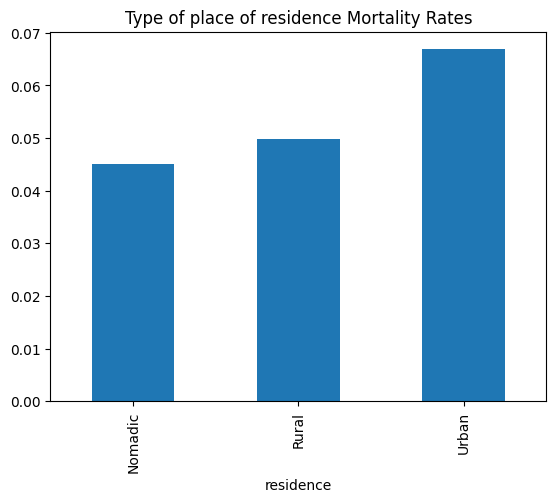

In [169]:
res = {1: "Urban", 2: "Rural", 3: "Nomadic"}
df["residence"] = df["V102"].map(res)
residence = df["residence"].value_counts()
residence_mortality = 1 - df.groupby("residence")["B5"].sum() / residence
residence_mortality.plot(kind="bar", stacked=True)
plt.title("Type of place of residence Mortality Rates")
plt.show()

In [147]:
diarrhea_ttt = [
    "H13",
    "H31B",
    "H14",
    "H15",
    "H15A",
    "H15B",
    "H15C",
    "H15D",
    "H15E",
    "H15F",
    "H15G",
    "H15H",
    "H15I",
]
diarrhea_sos = [
    "H12A",
    "H12B",
    "H12C",
    "H12D",
    "H12E",
    "H12G",
    "H12J",
    "H12K",
    "H12M",
    "H12S",
    "H12T",
    "H12U",
    "H12X",
]

df["diarrhea_treatment"] = df[diarrhea_ttt].any(axis=1).astype(int)
df["diarrhea_help"] = df[diarrhea_sos].any(axis=1).astype(int)

<Axes: xlabel='diarrhea_treatment'>

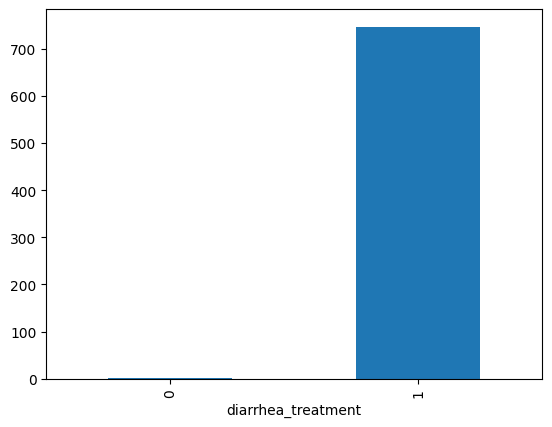

In [148]:
df[df["H11"] == 1].groupby("diarrhea_treatment")["B5"].sum().plot(kind="bar")
# does this mean, most of the people who take a treatment for diarrhea live? (these are just numbers, not rates)

<Axes: xlabel='diarrhea_help'>

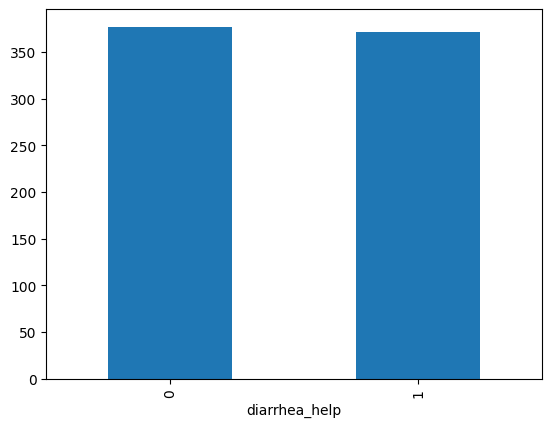

In [149]:
df[df["H11"] == 1].groupby("diarrhea_help")["B5"].sum().plot(kind="bar")

In [150]:
fever_cough_help = [
    "H32A",
    "H32B",
    "H32C",
    "H32D",
    "H32E",
    "H32G",
    "H32K",
    "H32S",
    "H32T",
    "H32X",
]
fever_cough_ttt = [
    "H37A",
    "H37B",
    "H37D",
    "H37DA",
    "H37E",
    "H37AA",
    "H37AB",
    "H37H",
    "H37I",
    "H37J",
    "H37K",
    "H37L",
    "H37L",
    "H37M",
    "H37X",
]

df["fever_cough_ttt"] = df[fever_cough_ttt].any(axis=1).astype(int)
df["fever_cough_help"] = df[fever_cough_help].any(axis=1).astype(int)

<Axes: xlabel='fever_cough_ttt'>

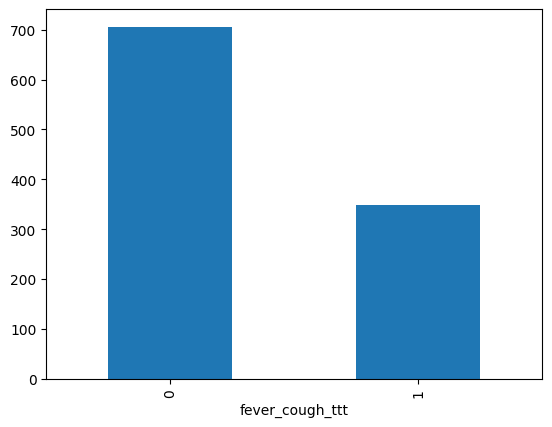

In [151]:
df[(df["H22"] == 1) | (df["ARI"] == 1)].groupby("fever_cough_ttt")["B5"].sum().plot(
    kind="bar"
)

<Axes: xlabel='fever_cough_help'>

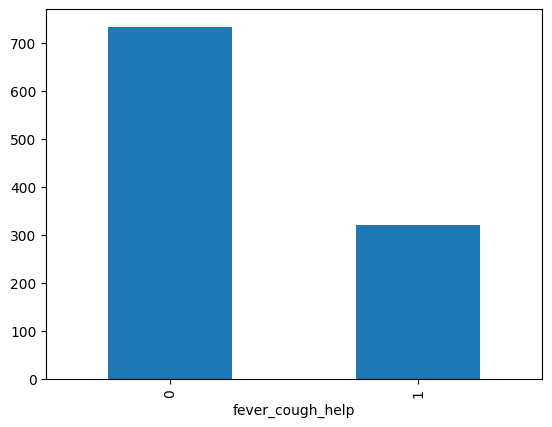

In [152]:
df[(df["H22"] == 1) | (df["ARI"] == 1)].groupby("fever_cough_help")["B5"].sum().plot(
    kind="bar"
)

In [153]:
df["M13"].value_counts()

M13
5.0    10548
0.0     4021
2.0      794
1.0      790
3.0      540
4.0      196
Name: count, dtype: int64

5 indicates missing/Don't know. I want to create a binary column that indicates whether the mother received ANC or not. It might be safer to include missingness as it's own category, though this might lead to misleading results, because it suggests that "not recorded" has substantive meaning (systematic missingness) when often it's just noise.

I'll consider missingness and don't know as "NO ANC"

In [154]:
df["ANC"] = np.where((df["M13"] == 0) | (df["M13"] == 5), 0, 1)

<Axes: xlabel='ANC'>

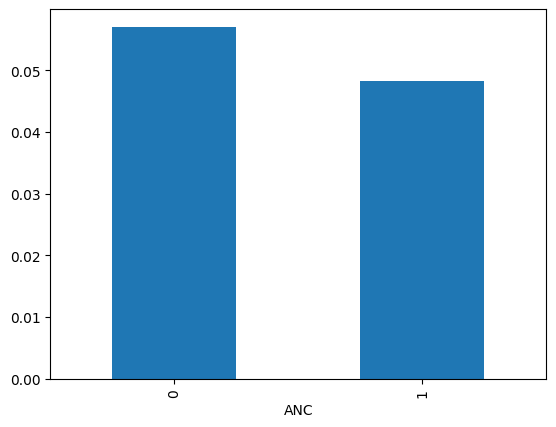

In [155]:
ANC_mortality = 1 - df.groupby("ANC")["B5"].sum() / df["ANC"].value_counts()
ANC_mortality.plot(kind="bar")

In [156]:
df["response"] = (
    (
        df[
            [
                "diarrhea_treatment",
                "diarrhea_help",
                "fever_cough_ttt",
                "fever_cough_help",
            ]
        ]
        == 1
    )
    .any(axis=1)
    .astype(int)
)

# Map The Outcome
Since we're looking at geographical hot-spots, the first step is exploratory spatial analysis:
- We aggregate the data at appropriate spatial units (regions)
- Calculate crude rates for mortality and morbidity
- Create choropleth maps to visualize rates.


In [157]:
# Map values of regions of the data set to their real names
regions = {
    11: "Awdal",
    12: "Woqooyi Galbeed",
    13: "Togdheer",
    14: "Sool",
    15: "Sanaag",
    16: "Bari",
    17: "Nugaal",
    18: "Mudug",
    19: "Galgaduud",
    20: "Hiiraan",
    21: "Middle Shebelle",
    22: "Banadir",
    23: "Lower Shebelle",
    24: "Bay",
    25: "Bakool",
    26: "Gedo",
    27: "Middle Juba",
    28: "Lower Juba",
}
df["regions"] = df["V024"].map(regions)

In [158]:
# Measuring Mortality
mortality = 1 - df.groupby("regions")["B5"].sum() / df["regions"].value_counts()
mortality_df = mortality.reset_index()
mortality_df.columns = ["regions", "mortality"]
mortality_df

,regions,mortality
0,Awdal,0.058824
1,Bakool,0.050832
2,Banadir,0.029185
3,Bari,0.056564
4,Bay,0.077121
5,Galgaduud,0.052036
6,Gedo,0.036120
7,Hiiraan,0.035806
8,Lower Juba,0.048828
9,Middle Shebelle,0.042735


In [159]:
# Measuring place of residence relation to regions
m = 1 - df.groupby("V026")["B5"].sum() / df["V026"].value_counts()
m_df = m.reset_index()
m_df.columns = ["district", "mortality"]
m_df

,district,mortality
0,1.0,0.056391
1,2.0,0.051643
2,3.0,0.029703
3,4.0,0.008547
4,5.0,0.042389
...,...,...
63,92.0,0.055118
64,93.0,0.062914
65,95.0,0.076923
66,100.0,0.029851


In [160]:
# Measuring Morbidity
sickness = df.groupby("regions")["sickness"].sum() / df["regions"].value_counts()
sickness_df = sickness.reset_index()
sickness_df.columns = ["regions", "sickness"]
sickness_df

,regions,sickness
0,Awdal,0.068627
1,Bakool,0.107209
2,Banadir,0.077643
3,Bari,0.113127
4,Bay,0.089974
5,Galgaduud,0.084842
6,Gedo,0.115583
7,Hiiraan,0.081841
8,Lower Juba,0.143555
9,Middle Shebelle,0.098901


In [161]:
# Measuring place of residence relation to regions
residence = df.groupby("regions")["V102"].value_counts()
residence

regions          V102
Awdal            2.0      411
                 1.0      291
                 3.0      114
Bakool           1.0      664
                 2.0      227
                 3.0      191
Banadir          3.0      705
                 2.0      701
                 1.0      410
Bari             1.0      421
                 3.0      301
                 2.0      215
Bay              1.0      269
                 3.0       85
                 2.0       35
Galgaduud        3.0      347
                 1.0      336
                 2.0      201
Gedo             3.0      526
                 2.0      234
                 1.0      209
Hiiraan          3.0      303
                 2.0      274
                 1.0      205
Lower Juba       2.0      477
                 1.0      353
                 3.0      194
Middle Shebelle  1.0      395
                 3.0      240
                 2.0      184
Mudug            2.0      435
                 3.0      321
                 1

In [162]:
# Load shapefile/geojson
gdf = gpd.read_file("geoBoundaries-SOM-ADM1.geojson")

# Get the centroid of the whole country
centroid = gdf.geometry.unary_union.centroid
latitude = centroid.y
longitude = centroid.x

m = folium.Map(location=[latitude, longitude], zoom_start=6)

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_27649/4134317631.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.geometry.unary_union.centroid


In [163]:
# Add choropleth
folium.Choropleth(
    geo_data=gdf,
    name="choropleth",
    data=mortality_df,
    columns=["regions", "mortality"],
    key_on="feature.properties.shapeName",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Mortality Rate",
).add_to(m)

folium.LayerControl().add_to(m)
m.save("somalia_map_mortality.html")

In [164]:
m = folium.Map(location=[latitude, longitude], zoom_start=6)

folium.Choropleth(
    geo_data=gdf,
    name="choropleth",
    data=sickness_df,
    columns=["regions", "sickness"],
    key_on="feature.properties.shapeName",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Sickness Rate",
).add_to(m)

folium.LayerControl().add_to(m)
m.save("somalia_map_sickness.html")

Warning: these figures indicate the number of cases found in the data file. They cannot be interpreted as summary statistics of the population of interest.

# Identify Hotspots Statistically
Mapping is useful, but to formally identify hotspots, we need to answer if clustering is statistically significant.
- Moran’s I: Moran’s I is a measure of spatial autocorrelation, which basically tells you whether values of a variable (like under-5 mortality or morbidity rates) are clustered, dispersed, or randomly distributed across geographic units.
  - It’s a global measure, meaning it gives an overall sense of clustering across the entire study area.
  - Identifies whether hotspots exist at all, without assuming any particular shape (like a circular window).

In [165]:
map_data = gdf.merge(mortality_df, left_on="shapeName", right_on="regions")

In [166]:
w = Queen.from_dataframe(map_data)
w.transform = "r"  # row-standardization

# Calculate Moran's I
y = map_data["mortality"].values
mi = Moran(y, w)

print("Moran's I:", mi.I)
print("p-value:", mi.p_sim)

Moran's I: 0.3031726615423809
p-value: 0.042


/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_27649/1397340688.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(map_data)


Moran’s I = 0.303 → Moderate positive spatial autocorrelation.
- This means that regions with high mortality tend to be near other regions with high mortality, and similarly for low mortality.
- So, mortality is not random in space—there is some clustering.

p-value = 0.042 → typically tested against α = 0.05.
- the clustering is statistically significant.
- The observed spatial pattern is unlikely to be due to random chance.

In [167]:
map_data = gdf.merge(sickness_df, left_on="shapeName", right_on="regions")
w = Queen.from_dataframe(map_data)
w.transform = "r"  # row-standardization

# Calculate Moran's I
y = map_data["sickness"].values
mi = Moran(y, w)

print("Moran's I:", mi.I)
print("p-value:", mi.p_sim)

Moran's I: 0.11015679085097349
p-value: 0.194


/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_27649/2926603661.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(map_data)


Moran’s I = 0.110 → very weak positive spatial autocorrelation.
- This means morbidity values are only slightly more similar in neighboring regions than you’d expect by chance.

p-value = 0.194 > 0.05 → not statistically significant.
- The observed weak clustering could easily be due to random chance.
- morbidity is fairly randomly distributed across the regions, unlike mortality.

### Why this difference may occur
This aligns with what I've noticed on the maps:
- Mortality clusters reflect serious outcomes, often driven by broader environmental, healthcare, or neonatal factors.
- Morbidity (diarrhea, fever, ARI) is more temporally variable, often affecting different regions in different survey periods, and depends on short-term exposures.
- Sampling effect: Some regions may have few children at the survey time, leading to noisy morbidity rates.


In [168]:
df.to_csv("KR_modified_df.csv")

The central research question guiding this analysis is whether there is a geographic clustering of mortality and morbidity in Somalia. Since I couldn't find a correlation between location and morbidity (mainly because it's difficult to be measured using only sickness symptoms which make hinders the process of prediction) I will focus on morbidity.

## Rationale for Focusing on Mortality Instead of Morbidity
While morbidity among children under five is an important public health outcome, in this study it presents several limitations that make it less suitable for predictive modeling and spatial analysis:

- **Measurement limitations**: Morbidity data is derived only from reported sickness symptoms (diarrhea, fever, acute respiratory infection) in the past two weeks. This short recall window captures episodic events rather than cumulative risk, and may miss other important causes of illness.

- **Rarity and spatial randomness**: Exploratory spatial analysis indicated that morbidity is weakly or randomly distributed across regions, with no significant geographic clustering. This makes it difficult to identify meaningful spatial patterns or hotspots that could inform targeted interventions.

- **Predictive challenges**: Because morbidity is highly variable, influenced by short-term environmental exposures, and not strongly clustered, any predictive model would likely have limited accuracy and interpretability.

In contrast, mortality shows **strong spatial clustering**, particularly in regions such as **Togdheer and Sool**. Mortality is a cumulative and more definitive outcome, reflecting the interplay of healthcare access, environmental factors, and socio-demographic conditions. Focusing on mortality allows the study to:
- Identify geographically significant hotspots where intervention is most needed.
- Explore contextual and environmental drivers behind these clusters using logistic regression, combining both individual- and region-level predictors.
- Provide actionable insights into the determinants of child survival, which is ultimately the most critical public health outcome.